In [44]:
from langgraph.graph import StateGraph,START,END
from langchain_groq import ChatGroq
from langchain_ollama import ChatOllama
from typing import TypedDict,Literal,Annotated
from pydantic import BaseModel,Field
import operator
from langchain_core.messages import SystemMessage,HumanMessage
from IPython.display import Image

In [45]:
class JdState(TypedDict):
    requirment : str
    iteration : int
    max_iteration : int
    jd : str
    evaluation : Literal["accept", "reject"]
    feedback : str

    jd_history : Annotated[list[str], operator.add]
    feedback_history : Annotated[list[str], operator.add]

In [46]:
class EvaluationScehma(BaseModel):
    feedback : str = Field(description="feedback for later generation")
    evaluation : Literal["accept","reject"] = Field(description="evalutation result")

In [47]:
# generate the jd
generator_model = ChatGroq(model="llama-3.1-8b-instant")

# evaluate the jd
model = ChatOllama(model="llama3")
evaluator_structured_model = model.with_structured_output(EvaluationScehma)

# for regeneration
optimizer_model = ChatGroq(model="llama-3.1-8b-instant")

In [ ]:
def generate_jd(state : JdState):
    messages = [
        SystemMessage(content="You are a professional job description generator."),
        HumanMessage(content=f"""
                \n\nGenerate the job description for the following requirments
                {state['requirment']}
                \n\nTLiteralhe JD should contain following things
                - Job Title
                - A highlight about key requirment of this job
                - Experience
                - About the Role
                - Key Responsibilities
                - Requirements
                - Location
                - Why Join Us?
                - Key Skills
                - About company
            """)
    ]
    output = generator_model.invoke(messages).content
    return {"jd" : output, "jd_history":[output], "iteration" : state['iteration'] + 1}

In [49]:
def evaluate_jd(state : JdState):
    message = [
        SystemMessage(content="You are a proffessional job description evaluator."),
        HumanMessage(content="""Evaluate the following jd based on the proffessionalism, quality of the jd and the format of the jd
    
        \n\n{state['jd']}""")
    ]

    output = evaluator_structured_model.invoke(message)
    return {"feedback" : output.feedback, "evaluation" : output.evaluation, "feedback_history" : [output.feedback]}

In [ ]:
def route_control(state : JdState) -> Literal["accept","reject"]:
    if state['evaluation'] == "accept" and state['iteration'] >= state['max_iteration']:
        return "accept"
    else:
        return "reject"


In [51]:
def optimizer_jd(state : JdState):
    message = [
        SystemMessage(content="You are a professional job description optimizer. Optimize the JD based on the feedback"),
        HumanMessage(content=f"""Optimize the following job description
        \n\nrequirment : "{state['requirment']}"
        \n\nOriginal JD : "{state['jd']}"
        \n\nFeedback : "{state['feedback']}"
        \n\nThe JD should contain following things
                - Job Title
                - A highlight about key requirment of this job
                - Experience
                - About the Role
                - Key Responsibilities
                - Requirements
                - Location
                - Why Join Us?
                - Key Skills
                - About company
            """)
    ]
    output = optimizer_model.invoke(message).content
    return {"jd" : output, "jd_history":[output], "iteration" : state['iteration'] + 1}

In [52]:
graph = StateGraph(JdState)

graph.add_node("generate_jd",generate_jd)
graph.add_node("evaluate_jd",evaluate_jd)
graph.add_node("optimizer_jd",optimizer_jd)

graph.add_edge(START, "generate_jd")
graph.add_edge("generate_jd", "evaluate_jd")
graph.add_conditional_edges("evaluate_jd", route_control, {"accept" : END, "reject" : "optimizer_jd"})
graph.add_edge("optimizer_jd", "evaluate_jd")

workflow = graph.compile()

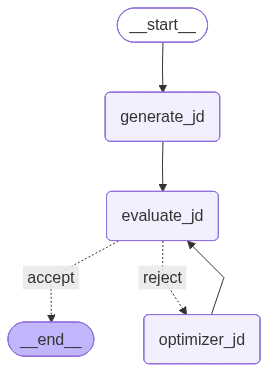

In [53]:
Image(workflow.get_graph().draw_mermaid_png())

In [54]:
requirment = """"We are looking for a highly skilled and motivated Data Scientist with strong expertise in Artificial Intelligence, Machine Learning, Deep Learning, and Generative AI to join our growing team. This role requires hands-on experience in building intelligent systems, working with large-scale data, and developing production-ready AI solutions. The ideal candidate should have a strong foundation in data science concepts, modern AI frameworks, and real-world problem-solving abilities, along with the ability to collaborate effectively across teams.

The candidate is expected to have 3 to 6 years of experience in the Data Science and AI/ML domain, with practical exposure to building, training, and deploying machine learning and deep learning models. Experience in Generative AI, including large language models and multimodal systems, is highly preferred. The role involves working with cutting-edge technologies to design scalable and high-performance AI solutions that solve business problems across domains.

In this role, you will be responsible for designing, developing, and deploying machine learning and deep learning models for real-world applications. You will work closely with cross-functional teams to understand business requirements and translate them into efficient AI solutions. The role also involves developing Generative AI use cases, working with large language models, optimizing models for performance and scalability, and ensuring seamless integration with production systems. You will also contribute to experimentation, model evaluation, and continuous improvement of AI pipelines.

The ideal candidate should have strong programming skills in Python and be comfortable working in Linux and Windows environments. A solid understanding of machine learning and deep learning frameworks such as TensorFlow, PyTorch, Keras, Pandas, and NumPy is required. Hands-on experience with Generative AI tools and frameworks such as LangChain, LlamaIndex, LangGraph, CrewAI, and NVIDIA NeMo or NIMs is highly desirable. The candidate should be familiar with deep learning architectures including Transformers, CNNs, and RNNs, along with experience in NLP, large language models, and multimodal AI systems such as GPT, LLaMA, Mistral, Qwen, or Nemotron. Experience with cloud platforms like AWS, Azure, or GCP, along with exposure to Docker, Kubernetes, and Git-based workflows, is also expected.

The position is based in India with flexibility across multiple locations and follows a hybrid working model. This role offers an excellent opportunity to work on advanced AI and Generative AI projects in a collaborative and innovation-driven environment. The organization provides exposure to cutting-edge technologies, opportunities for learning and growth, and the chance to work on impactful real-world solutions.

The ideal candidate should possess strong analytical thinking, problem-solving ability, and a passion for building intelligent systems. Certifications such as NVIDIA Certified Associate in Generative AI will be an added advantage. Strong communication skills and the ability to work effectively in a team-oriented environment are essential for success in this role.

This role is well suited for professionals who are eager to work at the forefront of AI innovation, contribute to enterprise-scale solutions, and grow their career in a dynamic and fast-paced environment.
"""

initial_state = {
    "requirment" : requirment,
    "iteration" : 1,
    "max_iteration" : 5
}

final_state = workflow.invoke(initial_state)

In [55]:
final_state

{'requirment': '"We are looking for a highly skilled and motivated Data Scientist with strong expertise in Artificial Intelligence, Machine Learning, Deep Learning, and Generative AI to join our growing team. This role requires hands-on experience in building intelligent systems, working with large-scale data, and developing production-ready AI solutions. The ideal candidate should have a strong foundation in data science concepts, modern AI frameworks, and real-world problem-solving abilities, along with the ability to collaborate effectively across teams.\n\nThe candidate is expected to have 3 to 6 years of experience in the Data Science and AI/ML domain, with practical exposure to building, training, and deploying machine learning and deep learning models. Experience in Generative AI, including large language models and multimodal systems, is highly preferred. The role involves working with cutting-edge technologies to design scalable and high-performance AI solutions that solve bus